##  Notebook 1 : Data Preprocessing

In this notebook, we are going to import our dataset, load embeddings and do some data preprocessing so as to make the dataset ready for traininig in our seq-to-seq model.

In [1]:
import pandas as pd
import gensim as gs
import pandas as pd
import numpy as np
import scipy as sc
import nltk
from nltk.tokenize import word_tokenize as wt
from nltk.tokenize import sent_tokenize as st
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.sequence import pad_sequences
import logging
import re
from collections import Counter
from tensorflow.contrib import keras

C:\Users\SrivatsanPC\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [2]:
data_path = "E:\\Spring-19\\Workshop\\data"
emb_size_all = 300
maxcorp=5000
seed = 42
vocab_size = 40000
import csv 

def load_data():
    review_df = pd.read_csv(data_path+'\\Reviews.csv',quoting=csv.QUOTE_NONE, error_bad_lines=True, encoding='utf8')
    review_df = review_df.dropna()
    print(len(review_df))
    data = {}
    data['articles'] = review_df['Text'].values
    data['summaries'] = review_df['Summary'].values
    return data



In [3]:
data = load_data()
heads,desc = list(data['summaries']),list(data['articles'])


C:\Users\SrivatsanPC\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (1,2,3,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


99993


In [4]:
i = 10
print('Text : ',desc[i])
print('Summary : ', heads[i])
print(type(heads[0]),type(desc[0]))

Text :  I don't know if it's the cactus or the tequila or just the unique combination of ingredients  but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed .<br /><br />Now  because of the magic of the internet  we have a case of the sauce and are ecstatic because of it .<br /><br />If you love hot sauce . .I mean really love hot sauce  but don't want a sauce that tastelessly burns your throat  grab a bottle of Tequila Picante Gourmet de Inclan .  Just realize that once you taste it  you will never want to use any other sauce .<br /><br />Thank you for the personal  incredible service!
Summary :  The Best Hot Sauce in the World
<class 'str'> <class 'str'>


In [5]:
from collections import Counter
from itertools import chain
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1]))
    return list(vocab), vocabcount

In [6]:
vocab, vocabcount = get_vocab(heads+desc)

In [7]:
print("Most common words : ", vocab[:50])


Most common words :  ['.', 'the', 'I', 'and', 'a', 'to', 'of', 'it', 'is', 'for', 'in', 'this', 'that', 'my', 'but', 'with', 'have', 'are', 'was', 'not', 'you', '.<br', '/><br', 'on', 'as', 'like', 'The', 'so', 'them', 'they', 'good', 'be', 'these', 'taste', 'or', 'at', 'just', 'one', 'very', 'flavor', 'product', 'great', 'from', 'This', 'It', 'all', 'can', 'coffee', 'more', 'tea']


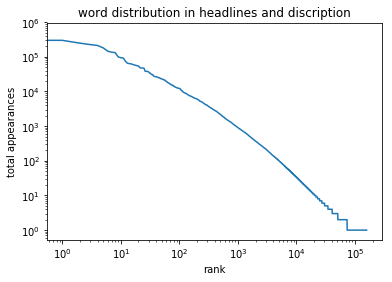

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances');

##### Lets form a dictionary of words.

In [9]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word

def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.items())

    return word2idx, idx2word

word2idx, idx2word = get_idx(vocab, vocabcount)
print('Vocabulary length :', len(word2idx))

Vocabulary length : 157770


##### Choose 100 dimensional embeddding. There are other GLoVe embeddings too and the user can choose whatever fits in memory. The bigger embeddings are usually more expressive.

In [10]:
embedding_dim = 100

#### Importing GLoVe embeddings

In [11]:
fname = 'glove.6B.%dd.txt'%embedding_dim
import os
datadir_base = 'E:\\Spring-19\\Workshop\\embeddings'
datadir = os.path.join(datadir_base, 'datasets')
glove_name = os.path.join(datadir, fname)
print(glove_name)

if not os.path.exists(glove_name):
    import pdb; pdb.set_trace()
    path = 'glove.6B.zip'
    if not os.path.exists(os.path.join(datadir, path)):
        path = keras.utils.get_file(os.path.join(datadir, path), origin="http://nlp.stanford.edu/data/glove.6B.zip")
    
    os.system("!unzip {datadir}/{path}")

E:\Spring-19\Workshop\embeddings\datasets\glove.6B.100d.txt


#### Assign words to GLOVe embeddings.

In [12]:
import numpy as np
glove_index_dict = {}
glove_embedding_weights = np.empty((400000, embedding_dim))
global_scale=.1
with open(glove_name, 'r',encoding="utf8") as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i        
        glove_embedding_weights[i,:] = [float(x) for x in l[1:]]
        i += 1
glove_embedding_weights *= global_scale


In [13]:
for w,i in glove_index_dict.items():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

#### Form embedding matrix

In [14]:
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print('random-embedding/glove scale', scale, 'std', embedding.std())

# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print('number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size))

random-embedding/glove scale 0.0706949139514209 std 0.04081382495746382
number of tokens, in small vocab, found in glove and copied to embedding 26330 0.65825


In [15]:
glove_thr = 0.5

word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

##### Find closest neighbors. 

Here we are finding neghbors that are the closest in terms of cosine distance  on the embedded space to make some sensible substitutions. We are using substitutes that are within 0.5(variable glove_thr) cosine distance.

In [16]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []
for w,idx in word2idx.items():    
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:        
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print('# of glove substitutes found', len(glove_match))

# of glove substitutes found 24364


In [24]:
for orig, sub, score in glove_match[10000:10010]:
    print(score, orig,'=>', idx2word[sub])

0.7522733867069938 Drunken => drunk
0.7522570535958253 implodes => disintegrates
0.7522525166772648 Revision => revised
0.7522525166772648 revision => revised
0.7522473039916444 curriculum => education
0.7522014052498005 boasted => boasting
0.7521937482355993 flashbacks => Flashback
0.7521338530465009 amorphous => crystalline
0.7520362698746801 diplomatic => relations
0.7520362698746801 Diplomatic => relations


In [18]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

99993


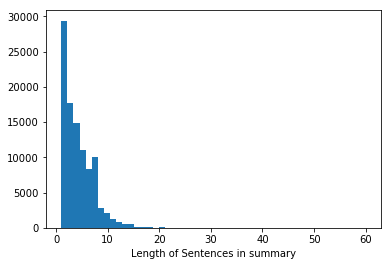

In [19]:
Y = [[word2idx[token] for token in headline.split()] for headline in heads]
print(len(Y))
plt.hist([len(p) for p in Y],bins=50);
plt.xlabel('Length of Sentences in summary')

##### Convert data into corresponding id(number) tokens and save them.

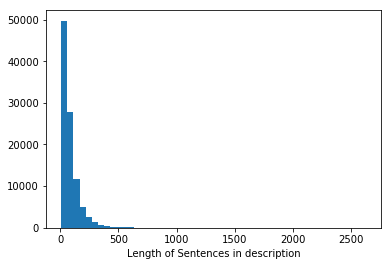

In [20]:
X = [[word2idx[token] for token in d.split()] for d in desc]
len(X)
plt.hist([len(p) for p in X],bins=50)
plt.xlabel('Length of Sentences in description')

In [21]:
import pickle
pickle_path = 'E:\\Spring-19\\Workshop\\saved_models'
FN = 'embeddings.pkl'
with open(os.path.join(pickle_path,FN),'wb') as fp:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)

In [22]:
FN = 'data.pkl'
with open(os.path.join(pickle_path,FN),'wb') as fp:
    pickle.dump((X,Y),fp,-1)

##### Sanity Checks

In [23]:
print(X[0],Y[0])
print("Sentence : ",  [idx2word[p] for p in X[0]])
print("Summary : ", [idx2word[p] for p in Y[0]])

[4, 18, 141, 349, 8, 3, 10910, 570, 83, 56, 232, 5, 18, 120, 30, 47, 7, 33, 8, 32, 184, 2, 28, 42, 649, 50, 27, 6, 4633, 57, 6, 1357, 488, 5, 9, 699, 97, 2, 65, 9223, 10, 2053, 5, 124, 11584, 13, 42, 97, 57, 170, 2] [198, 1779, 642, 787]
Sentence :  ['I', 'have', 'bought', 'several', 'of', 'the', 'Vitality', 'canned', 'dog', 'food', 'products', 'and', 'have', 'found', 'them', 'all', 'to', 'be', 'of', 'good', 'quality', '.', 'The', 'product', 'looks', 'more', 'like', 'a', 'stew', 'than', 'a', 'processed', 'meat', 'and', 'it', 'smells', 'better', '.', 'My', 'Labrador', 'is', 'finicky', 'and', 'she', 'appreciates', 'this', 'product', 'better', 'than', 'most', '.']
Summary :  ['Good', 'Quality', 'Dog', 'Food']
